<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Vorticity, streamfunction, and velocity
In this notebook we will discuss the relationship between vorticity ($\omega$),
velocity ($\mathbf{u}$), and streamfunction ($\psi$), in two-dimensional flows:

$$ \nabla^2\psi = -\omega $$

and

$$ \mathbf{u} = \nabla\times (\psi \mathbf{k}) $$

We will do this by considering some example vorticity distributions, formed from one or
more vortices of the form

$$ \omega(x,y) = \dfrac{\Gamma}{\pi \sigma^2} \mathrm{e}^{-((x-x0)^2+(y-y0)^2)/\sigma^2} $$

This shape is called a *Gaussian*, and physically, represents a type of vortex called an Oseen
vortex. The parameter $\Gamma$ is the circulation of this vortex, $\sigma$ is its radius,
and $(x0,y0)$ its center.

### Set up the module

In [1]:
using FluidDynTools

In [2]:
using Plots

### Set up a grid on which to construct our fields and associated cache
This is done the same way as in the previous notebook

In [3]:
Δx = 0.02
xlim = (-2,2)
ylim = (-2,2)
g = PhysicalGrid(xlim,ylim,Δx)
cache = SurfaceVectorCache(g);

 ### Example: a Gaussian (or *Oseen*) vortex
We will obtain the velocity field associated with an Oseen vortex centered at the origin.
An Oseen vortex has vorticity distributed in a Gaussian fashion
In order to create a Gaussian distribution, we can make use of the `SpatialGaussian` function:

In [4]:
Γ = 1
σ = 0.2
x0 = 0.0
y0 = 0.0
gauss1 = SpatialGaussian(σ,σ,x0,y0,Γ);

Then, we can evaluate this distribution on our grid. The first step
creates some blank data of `curl-type` data (e.g., vorticity).

The second step evaluates the Gaussian and places the results in `ω`.

In [5]:
ω = zeros_gridcurl(cache);
evaluate_field!(ω,gauss1,cache);

Now plot the vorticity field

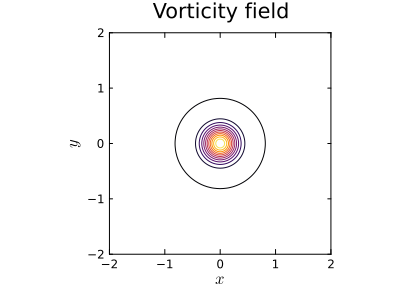

In [6]:
plot(ω,cache,xlim=(-2,2),ylim=(-2,2),levels=range(0.001,10,length=31),xlabel=L"x",ylabel=L"y",title="Vorticity field")

#### Now let's compute the streamfunction
We need to solve the Poisson equation to get the streamfunction, $\psi$:

$$ \nabla^2 \psi = -\omega $$

Details, if interested: In the creation of the `cache` earlier, we have set up
a discrete version of the Laplacian operator on the grid (using finite differences).
This is basically a matrix that multiplies a vector of grid data.
What we are using here is the *inverse* of this operator, something
called the lattice Green's function.
Set ψ as a temporary placeholder for -ω

In [7]:
ψ = -ω;

Then, after the following step, ψ is now the solution of the problem.
(This is called solving *in place*, since ψ enters as the right-hand side
 of this problem, and exits as the solution.)

In [8]:
inverse_laplacian!(ψ,cache);

Plot the streamfunction contours

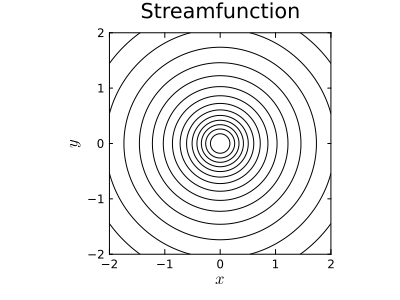

In [9]:
plot(ψ,cache,color=:Black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Streamfunction")

Remember that each of these contours of streamfunction is a **streamline**. The only drawback
is that the arrows aren't on it. (How would you determine the direction of the streamlines?)

It probably is not a surprise that the streamlines of a radially-symmetric vortex are a bunch
of concentric circles. This makes it clear that a vortex is a region of rotational flow.

#### Finally, compute the velocity field
Here, we take the curl of the streamfunction (treating the streamfunction as a vector
directed out of the screen),

$$ \mathbf{u} = \nabla\times (\psi\mathbf{k}) $$

First, we set up a blank set of velocity field data `vel`. Then we evaluate
the curl. The discrete curl operator is simply called `curl!` (the ! indicates
that `vel` is being changed by the action of this function.

In [10]:
vel = zeros_grid(cache)
curl!(vel,ψ,cache);

Now plot them

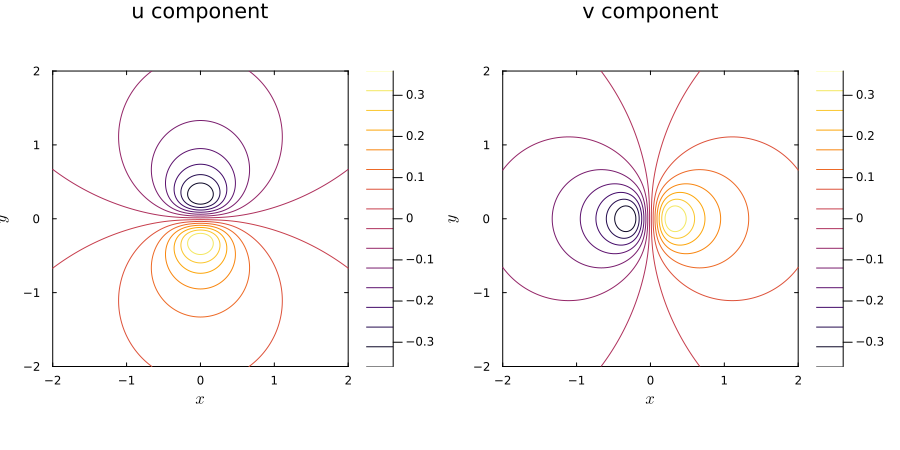

In [11]:
plot(
    plot(vel.u,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="u component",colorbar=:true),
    plot(vel.v,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="v component",colorbar=:true),
    size=(900,450))

These are not as obvious to interpret. But with a little bit of thought, you can see
that regions of large $x$ velocity are above and below the vortex, and regions of large $y$
velocity are on the sides.

#### The velocity magnitude
The speed of the flow, $|\mathbf{u}|$, is a little easier to interpret. But where is the
speed the largest?

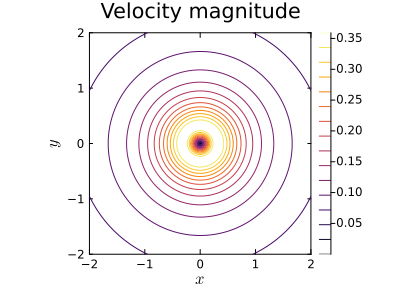

In [12]:
umag = mag(vel);
plot(umag,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Velocity magnitude",colorbar=:true)

To see the speed distribution a little better, try plotting along a slice $y = 0$.

For those that like details: To get this slice, we construct a function that interpolates the
velocity magnitude field on the grid, and we can then evaluate that function at any $x,y$ location
we like. Here, we will evaluate it at $y = 0$ in a range of points along the $x$ axis."

In [13]:
umag_fcn = interpolatable_field(umag,g);

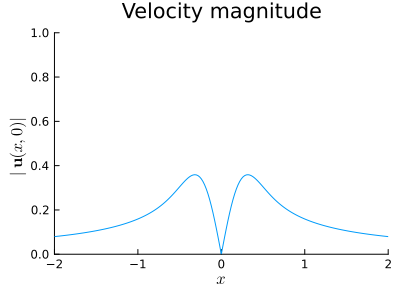

In [14]:
xc,yc = coordinates(umag,g)
plot(xc,umag_fcn.(xc,0),xlim=(-2,2),ylim=(0,1),xlabel=L"x",ylabel=L"|\mathbf{u}(x,0)|",title="Velocity magnitude",legend=false)

The velocity is actually zero at the center and maximum a little bit away from the center.
Try changing $\sigma$ and seeing how this location of maximum speed changes.

### Construct a pair of vortices
Now, let's try putting more than one vortex together.

In [15]:
Γ = 1
σ = 0.3
gauss2 = SpatialGaussian(σ,σ,-1,0,Γ) + SpatialGaussian(σ,σ,1,0,Γ);

In [16]:
evaluate_field!(ω,gauss2,cache);

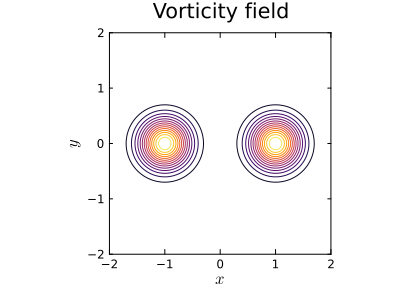

In [17]:
plot(ω,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Vorticity field")

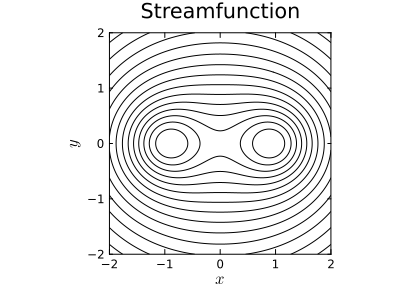

In [18]:
ψ = -ω
inverse_laplacian!(ψ,cache)
plot(ψ,cache,color=:black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Streamfunction")

#### Stagnation points
Where are the stagnation points for this flow? There are a few ways to hunt for them:
* where streamlines cross
* where velocity components both vanish
* where velocity magnitude is zero

Let's try the second approach. We will plot the zero contour (the contour for which the value
is zero) of the $x$ and $y$ components of velocity and lay them on top of each other. Stagnation
points correspond to where the zero contours of each component cross. We will put the streamlines
in the plot, too, just for reference.

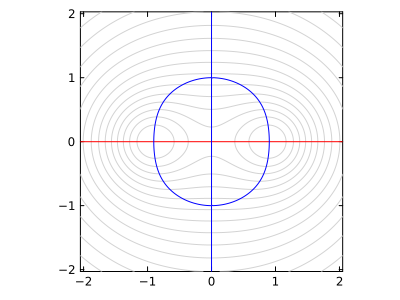

In [19]:
curl!(vel,ψ,cache)
plot(ψ,cache,color=:lightgray)
plot!(vel.u,cache,levels=[0],color=:red,xlim=(-2,2),ylim=(-2,2)) # x component in red
plot!(vel.v,cache,levels=[0],color=:blue) # y component in red

So there are three stagnation points: one near each of the vortex centers and a third one
right at the origin.

### Make some other vorticity fields and explore the associated streamlines here
Add more vortices, change their locations, their strengths (positive or negative),
their radius. Explore!

In [20]:
Γ = 1
σ = 0.3
gauss4 = SpatialGaussian(σ,σ,-1,0,-Γ) + SpatialGaussian(σ,σ,1,0,-Γ) + SpatialGaussian(σ,σ,0,1,Γ) + SpatialGaussian(σ,σ,0,-1,Γ);

In [21]:
evaluate_field!(ω,gauss2,cache);

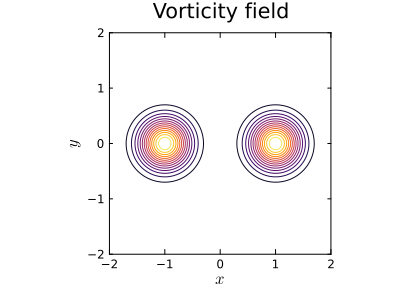

In [22]:
plot(ω,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Vorticity field")

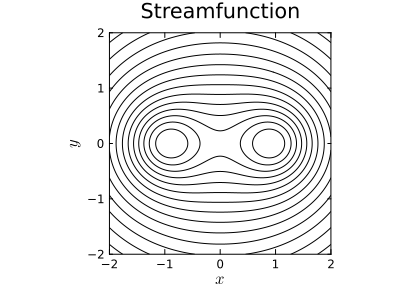

In [23]:
ψ = -ω
inverse_laplacian!(ψ,cache)
ps = plot(ψ,cache,color=:black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Streamfunction")

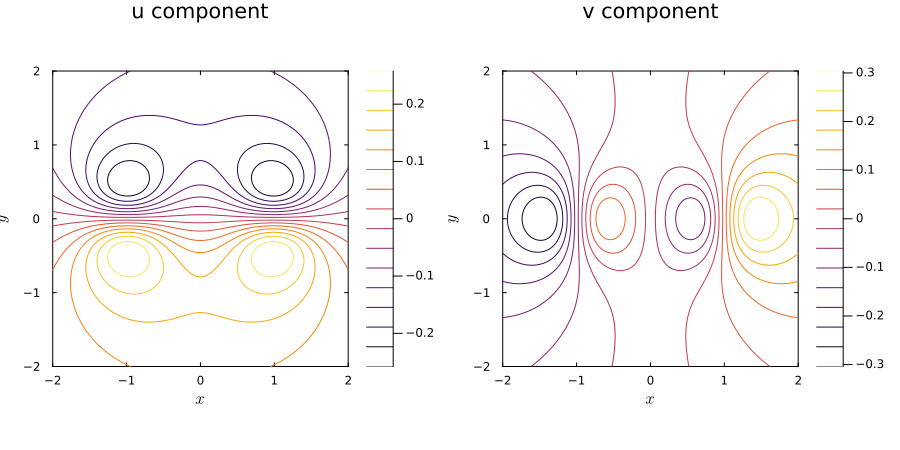

In [24]:
curl!(vel,ψ,cache)
plot(
    plot(vel.u,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="u component",colorbar=:true),
    plot(vel.v,cache,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="v component",colorbar=:true),
    size=(900,450))

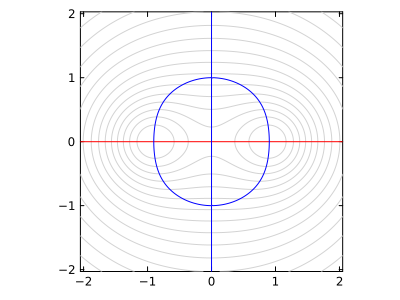

In [25]:
plot(ψ,cache,color=:lightgray)
plot!(vel.u,cache,levels=[0],color=:red,xlim=(-2,2),ylim=(-2,2)) # x component in red
plot!(vel.v,cache,levels=[0],color=:blue) # y component in red

We can find the zeros of the stagnation points by looking for the minima of $|\mathbf{u}|^2$.
For this, we will use the `NLsolve` package:

In [26]:
using NLsolve

This calculates $|\mathbf{u}|^2$ on the grid.

In [27]:
umagsq = magsq(vel);

Now we create an interpolatable field of |\mathbf{u}|^2

In [28]:
umagsq_fcn = interpolatable_field(umagsq,g);

`nlsolve` needs a function that evaluates |\mathbf{u}|^2 at any point.

In [29]:
function f!(F,x)
    F[1] = umagsq_fcn(x[1],x[2])
end

f! (generic function with 1 method)

Now, we make an initial guess for where a stagnation point is, and let `nlsolve`
do the rest. It seeks to find the point

In [30]:
xguess = [1.0,0.1]
sol = nlsolve(f!, xguess)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 0.1]
 * Zero: [0.9029030186062684, -7.585133565352412e-7]
 * Inf-norm of residuals: 0.100000
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 25
 * Jacobian Calls (df/dx): 12

This found a solution (though it did not actually converge...) Let's plot the
result to see if it looks correct. We use `scatter!` to add the point to the
plot. Note that `scatter` expects an array of x locations and an array of
y locations, whereas `sol.zero` is a single array, containing the coordinates
where `nlsolve` found the zero. So we have to put these separately into brackets:

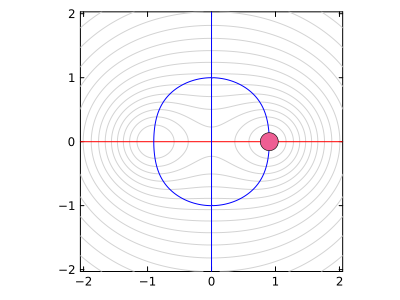

In [31]:
plot(ψ,cache,color=:lightgray)
plot!(vel.u,cache,levels=[0],color=:red,xlim=(-2,2),ylim=(-2,2)) # x component in red
plot!(vel.v,cache,levels=[0],color=:blue)
scatter!([sol.zero[1]],[sol.zero[2]],markersize=10)

You can do this for the other stagnation points, too. Just change your initial guess.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*